# Ch9 | LoRA 与量化：面向消费级 GPU 的高效微调

---

**目标：** 在有限 GPU 显存下学习如何微调大模型

**本 notebook 使用 PEFT 和 GPT-2 演示真实的 LoRA 微调。**

**设备建议：** GPU；CPU 仅建议阅读/演示。

---

## 内容

1. **LoRA 原理**：低秩矩阵分解
2. **从零实现**：手动实现 LoRA
3. **量化**：4-bit 与 8-bit 精度
4. **真实训练**：使用 PEFT 进行 LoRA 微调


## 挑战：微调大模型

### 全量微调的显存需求

以 7B 模型为例：
```
模型参数: 7B × 2 bytes (FP16) = 14 GB
梯度:     7B × 2 bytes = 14 GB  
优化器(Adam): 7B × 8 bytes = 56 GB
----------------------------------------
总计: 约 84 GB GPU 显存
```

**消费级 GPU（16-24GB）无法承受！**

### 解决方案

| 技术 | 显存节省 | 原理 |
|-----------|---------------|-------------|
| **LoRA** | 可训练参数减少约 100x | 低秩分解 |
| **量化** | 2-8x | 降低精度 |
| **QLoRA** | 组合方案 | 两者结合 |


## 环境准备


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.1 GB


In [2]:
# Install required packages
try:
    from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
    print("Transformers loaded!")
except ImportError:
    !pip install transformers accelerate -q
    from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer

try:
    from peft import LoraConfig, get_peft_model, TaskType, PeftModel, prepare_model_for_kbit_training
    PEFT_AVAILABLE = True
    print("PEFT library loaded!")
except ImportError:
    PEFT_AVAILABLE = False
    print("PEFT not available - install with: pip install peft")

try:
    import bitsandbytes as bnb
    BNB_AVAILABLE = True
    print("bitsandbytes loaded (for quantization)!")
except Exception as e:
    import sys
    BNB_AVAILABLE = False
    print(f"bitsandbytes import failed: {type(e).__name__}: {e}")
    print(f"Python: {sys.executable}")

Transformers loaded!
PEFT library loaded!
bitsandbytes loaded (for quantization)!


## Part 1：理解 LoRA

### 核心思想

不训练所有权重时，LoRA 会：
1. **冻结** 原始的预训练权重
2. **新增** 一个小的可训练“增量”（delta）

$$W_{new} = W_{frozen} + \Delta W$$

### 低秩分解

关键洞见：$\Delta W$ 可以表示为：

$$\Delta W = B \times A$$

其中：
- $A$：[r, input_dim] —— “下投影”
- $B$：[output_dim, r] —— “上投影”
- $r$：秩（通常 4-64，远小于原维度）


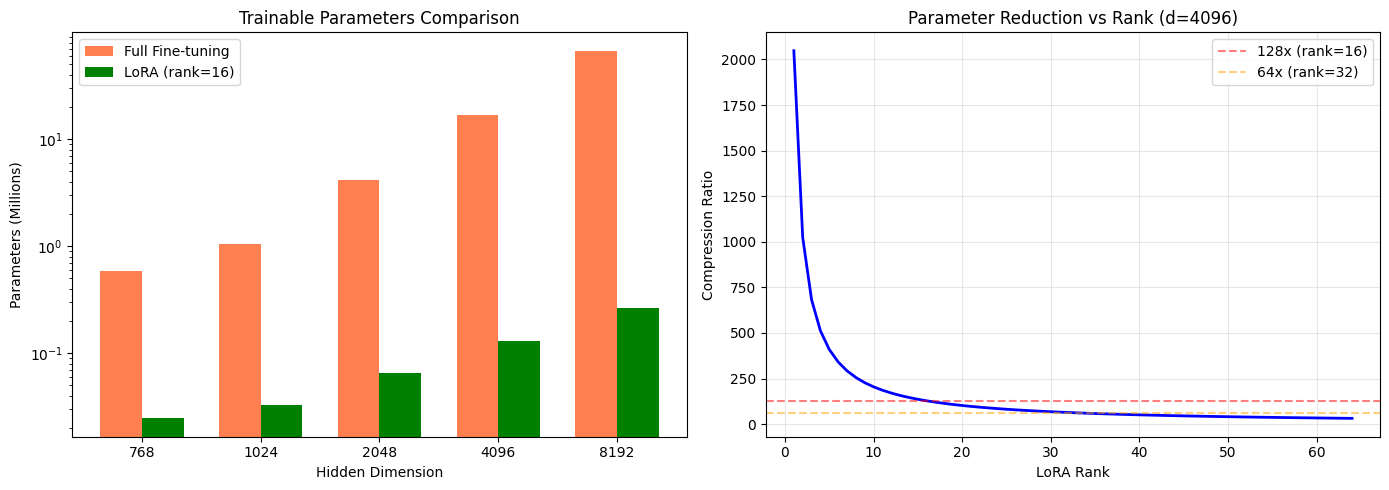


Parameter comparison for d=4096 (typical LLM hidden size):
  rank= 4: Full=16.8M, LoRA=33K, Compression=512x
  rank= 8: Full=16.8M, LoRA=66K, Compression=256x
  rank=16: Full=16.8M, LoRA=131K, Compression=128x
  rank=32: Full=16.8M, LoRA=262K, Compression=64x


In [3]:
# Visualize LoRA parameter savings

def calculate_params(d_in, d_out, rank):
    """Calculate parameters for full vs LoRA"""
    full_params = d_in * d_out
    lora_params = d_in * rank + rank * d_out
    return full_params, lora_params

dimensions = [768, 1024, 2048, 4096, 8192]
ranks = [4, 8, 16, 32]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Parameter comparison for rank=16
rank = 16
full_params = [d * d for d in dimensions]
lora_params = [d * rank + rank * d for d in dimensions]

x = np.arange(len(dimensions))
width = 0.35

axes[0].bar(x - width/2, np.array(full_params)/1e6, width, label='Full Fine-tuning', color='coral')
axes[0].bar(x + width/2, np.array(lora_params)/1e6, width, label=f'LoRA (rank={rank})', color='green')
axes[0].set_xlabel('Hidden Dimension')
axes[0].set_ylabel('Parameters (Millions)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(dimensions)
axes[0].set_title('Trainable Parameters Comparison')
axes[0].legend()
axes[0].set_yscale('log')

# Plot 2: Compression ratio vs rank
d = 4096  # GPT-2 large dimension
compression_ratios = []
for r in range(1, 65):
    full, lora = calculate_params(d, d, r)
    compression_ratios.append(full / lora)

axes[1].plot(range(1, 65), compression_ratios, 'b-', linewidth=2)
axes[1].axhline(y=128, color='r', linestyle='--', alpha=0.5, label='128x (rank=16)')
axes[1].axhline(y=64, color='orange', linestyle='--', alpha=0.5, label='64x (rank=32)')
axes[1].set_xlabel('LoRA Rank')
axes[1].set_ylabel('Compression Ratio')
axes[1].set_title(f'Parameter Reduction vs Rank (d={d})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print specific examples
print("\nParameter comparison for d=4096 (typical LLM hidden size):")
for r in [4, 8, 16, 32]:
    full, lora = calculate_params(4096, 4096, r)
    print(f"  rank={r:2d}: Full={full/1e6:.1f}M, LoRA={lora/1e3:.0f}K, Compression={full/lora:.0f}x")

## Part 2：从零实现 LoRA


In [4]:
class LoRALinear(nn.Module):
    """
    LoRA implementation for a Linear layer.
    
    Mathematical formulation:
        y = Wx + (BA)x * scaling
        
    Where:
        W: Original frozen weights [out_features, in_features]
        A: Down projection [rank, in_features]
        B: Up projection [out_features, rank]
        scaling: alpha / rank (controls magnitude of LoRA contribution)
    """
    
    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        rank: int = 4,
        alpha: float = 1.0,
        dropout: float = 0.0
    ):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        
        # Original frozen linear layer
        self.linear = nn.Linear(in_features, out_features)
        self.linear.weight.requires_grad = False
        if self.linear.bias is not None:
            self.linear.bias.requires_grad = False
        
        # LoRA matrices
        # A: initialized with small random values (Kaiming)
        # B: initialized to zero (ensures ΔW = 0 at start)
        self.lora_A = nn.Parameter(torch.empty(rank, in_features))
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))
        
        # Initialize A with Kaiming uniform
        nn.init.kaiming_uniform_(self.lora_A, a=np.sqrt(5))
        
        # Optional dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: y = Wx + (BA)x * scaling
        """
        # Original output (frozen)
        original_output = self.linear(x)
        
        # LoRA contribution: x @ A^T @ B^T * scaling
        lora_output = self.dropout(x)
        lora_output = F.linear(lora_output, self.lora_A)  # x @ A^T
        lora_output = F.linear(lora_output, self.lora_B)  # (xA^T) @ B^T
        lora_output = lora_output * self.scaling
        
        return original_output + lora_output
    
    def merge_weights(self):
        """
        Merge LoRA weights into the original weights for efficient inference.
        After merging, no additional computation is needed.
        """
        with torch.no_grad():
            # W_new = W + (BA) * scaling
            delta_w = (self.lora_B @ self.lora_A) * self.scaling
            self.linear.weight.add_(delta_w)
    
    def get_trainable_params(self) -> int:
        return self.lora_A.numel() + self.lora_B.numel()
    
    def get_frozen_params(self) -> int:
        params = self.linear.weight.numel()
        if self.linear.bias is not None:
            params += self.linear.bias.numel()
        return params
    
    def __repr__(self):
        return (
            f"LoRALinear(in={self.in_features}, out={self.out_features}, "
            f"rank={self.rank}, alpha={self.alpha})"
        )

In [5]:
# Test our LoRA implementation
print("Testing LoRA Linear Layer")
print("=" * 50)

lora_layer = LoRALinear(1024, 1024, rank=16, alpha=32)
print(f"Layer: {lora_layer}")
print(f"\nParameter counts:")
print(f"  Frozen params: {lora_layer.get_frozen_params():,}")
print(f"  Trainable params: {lora_layer.get_trainable_params():,}")
print(f"  Compression: {lora_layer.get_frozen_params() / lora_layer.get_trainable_params():.1f}x")

# Test forward pass
x = torch.randn(2, 10, 1024)
y = lora_layer(x)
print(f"\nForward pass:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {y.shape}")

# Verify initialization (B=0 means ΔW=0 initially)
original_out = lora_layer.linear(x)
diff = (y - original_out).abs().max().item()
print(f"\nInitialization check:")
print(f"  Max difference from original: {diff:.6f}")
print(f"  (Should be ~0 because B is initialized to zero)")

Testing LoRA Linear Layer
Layer: LoRALinear(in=1024, out=1024, rank=16, alpha=32)

Parameter counts:
  Frozen params: 1,049,600
  Trainable params: 32,768
  Compression: 32.0x

Forward pass:
  Input shape: torch.Size([2, 10, 1024])
  Output shape: torch.Size([2, 10, 1024])

Initialization check:
  Max difference from original: 0.000000
  (Should be ~0 because B is initialized to zero)


In [6]:
# Verify gradient flow
print("Gradient Flow Verification")
print("=" * 50)

lora_layer = LoRALinear(512, 512, rank=8)
x = torch.randn(4, 8, 512, requires_grad=True)
y = lora_layer(x)
loss = y.sum()
loss.backward()

print(f"Frozen weight gradient: {lora_layer.linear.weight.grad}")
print(f"LoRA A gradient shape: {lora_layer.lora_A.grad.shape}")
print(f"LoRA B gradient shape: {lora_layer.lora_B.grad.shape}")
print(f"\nGradients flow to LoRA params but NOT to frozen weights!")

Gradient Flow Verification
Frozen weight gradient: None
LoRA A gradient shape: torch.Size([8, 512])
LoRA B gradient shape: torch.Size([512, 8])

Gradients flow to LoRA params but NOT to frozen weights!


## Part 3：量化基础

量化通过使用更低精度来降低显存占用：

| 精度 | 字节/参数 | 7B 模型大小 |
|-----------|-------------|---------------|
| FP32 | 4 | 28 GB |
| FP16 | 2 | 14 GB |
| INT8 | 1 | 7 GB |
| INT4 | 0.5 | 3.5 GB |


In [7]:
def quantize_tensor_symmetric(tensor: torch.Tensor, bits: int = 8) -> tuple:
    """
    Symmetric quantization: maps values to [-2^(bits-1), 2^(bits-1) - 1]
    
    Returns:
        quantized tensor, scale factor
    """
    # Find the maximum absolute value
    max_val = tensor.abs().max()
    
    # Calculate scale
    q_max = 2 ** (bits - 1) - 1
    scale = max_val / q_max
    
    # Quantize
    quantized = (tensor / scale).round().clamp(-q_max, q_max)
    
    return quantized.to(torch.int8), scale


def dequantize_tensor(quantized: torch.Tensor, scale: float) -> torch.Tensor:
    """Dequantize back to float"""
    return quantized.float() * scale


def quantize_per_channel(tensor: torch.Tensor, bits: int = 8) -> tuple:
    """
    Per-channel quantization: each output channel has its own scale.
    More accurate than per-tensor quantization.
    """
    # For weight matrix [out_features, in_features], quantize per output channel
    max_vals = tensor.abs().max(dim=1, keepdim=True)[0]
    
    q_max = 2 ** (bits - 1) - 1
    scales = max_vals / q_max
    scales = scales.clamp(min=1e-8)  # Avoid division by zero
    
    quantized = (tensor / scales).round().clamp(-q_max, q_max)
    
    return quantized.to(torch.int8), scales.squeeze()


# Test quantization
print("Quantization Test")
print("=" * 50)

# Create a sample weight matrix
original = torch.randn(512, 512)

# Test different quantization methods
for bits in [8, 4]:
    q_tensor, scale = quantize_tensor_symmetric(original, bits)
    reconstructed = dequantize_tensor(q_tensor, scale)
    error = (original - reconstructed).abs()
    
    print(f"\n{bits}-bit symmetric quantization:")
    print(f"  Original size: {original.numel() * 4 / 1024:.1f} KB (FP32)")
    print(f"  Quantized size: {q_tensor.numel() * (bits/8) / 1024:.1f} KB")
    print(f"  Compression: {32/bits:.1f}x")
    print(f"  Mean error: {error.mean():.6f}")
    print(f"  Max error: {error.max():.6f}")

Quantization Test

8-bit symmetric quantization:
  Original size: 1024.0 KB (FP32)
  Quantized size: 256.0 KB
  Compression: 4.0x
  Mean error: 0.009078
  Max error: 0.018123

4-bit symmetric quantization:
  Original size: 1024.0 KB (FP32)
  Quantized size: 128.0 KB
  Compression: 8.0x
  Mean error: 0.164507
  Max error: 0.328807


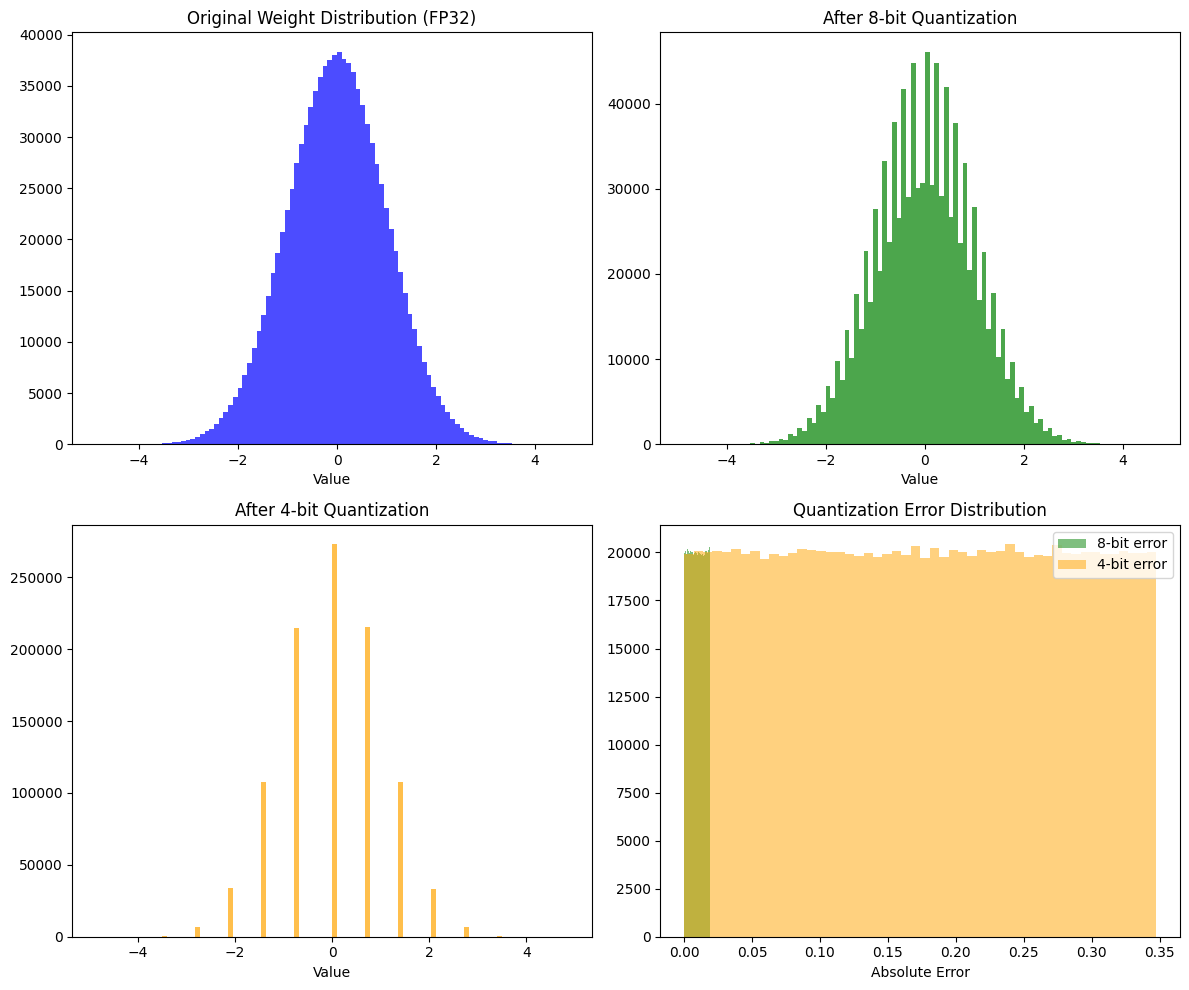

In [8]:
# Visualize quantization effects
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

original = torch.randn(1000, 1000)

# Original distribution
axes[0, 0].hist(original.flatten().numpy(), bins=100, color='blue', alpha=0.7)
axes[0, 0].set_title('Original Weight Distribution (FP32)')
axes[0, 0].set_xlabel('Value')

# 8-bit quantization
q8, s8 = quantize_tensor_symmetric(original, 8)
r8 = dequantize_tensor(q8, s8)
axes[0, 1].hist(r8.flatten().numpy(), bins=100, color='green', alpha=0.7)
axes[0, 1].set_title('After 8-bit Quantization')
axes[0, 1].set_xlabel('Value')

# 4-bit quantization
q4, s4 = quantize_tensor_symmetric(original, 4)
r4 = dequantize_tensor(q4, s4)
axes[1, 0].hist(r4.flatten().numpy(), bins=100, color='orange', alpha=0.7)
axes[1, 0].set_title('After 4-bit Quantization')
axes[1, 0].set_xlabel('Value')

# Error comparison
error_8 = (original - r8).abs().flatten().numpy()
error_4 = (original - r4).abs().flatten().numpy()
axes[1, 1].hist(error_8, bins=50, alpha=0.5, label='8-bit error', color='green')
axes[1, 1].hist(error_4, bins=50, alpha=0.5, label='4-bit error', color='orange')
axes[1, 1].set_title('Quantization Error Distribution')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Part 4：使用 PEFT 进行真实 LoRA 微调

现在我们在 GPT-2 上进行实际的 LoRA 微调！


In [9]:
# Load Chinese GPT-2 model and tokenizer
model_name = "uer/gpt2-chinese-cluecorpussmall"  # Chinese GPT-2 base

print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Ensure the tokenizer has a pad token
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = tokenizer.pad_token_id

total_params = sum(p.numel() for p in model.parameters())
print(f"Model loaded: {total_params:,} parameters")
print(f"Memory: {total_params * 4 / 1e9:.2f} GB (FP32)")

Loading uer/gpt2-chinese-cluecorpussmall...
Model loaded: 102,068,736 parameters
Memory: 0.41 GB (FP32)


In [10]:
if PEFT_AVAILABLE:
    # Configure LoRA
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=16,  # Rank
        lora_alpha=32,  # Scaling factor
        lora_dropout=0.1,
        # Which layers to apply LoRA to
        target_modules=["c_attn", "c_proj"],  # GPT-2 attention layers
        bias="none",
    )
    
    print("LoRA Configuration:")
    print(f"  Rank (r): {lora_config.r}")
    print(f"  Alpha: {lora_config.lora_alpha}")
    print(f"  Dropout: {lora_config.lora_dropout}")
    print(f"  Target modules: {lora_config.target_modules}")
else:
    print("PEFT not available. Install with: pip install peft")

LoRA Configuration:
  Rank (r): 16
  Alpha: 32
  Dropout: 0.1
  Target modules: {'c_attn', 'c_proj'}


In [11]:
if PEFT_AVAILABLE:
    # Create LoRA model
    lora_model = get_peft_model(model, lora_config)
    
    # Print trainable parameters
    lora_model.print_trainable_parameters()
    
    # Get detailed parameter info
    trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in lora_model.parameters())
    
    print(f"\nDetailed breakdown:")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Total parameters: {all_params:,}")
    print(f"  Trainable %: {100 * trainable_params / all_params:.4f}%")
    print(f"  Memory for LoRA params: {trainable_params * 4 / 1e6:.2f} MB")

trainable params: 1,622,016 || all params: 103,690,752 || trainable%: 1.5643

Detailed breakdown:
  Trainable parameters: 1,622,016
  Total parameters: 103,690,752
  Trainable %: 1.5643%
  Memory for LoRA params: 6.49 MB


In [12]:
# Prepare training data
import random

ISSUE_LABELS = ["延迟发货", "退款申请", "地址修改", "物流异常", "售后咨询", "发票问题"]
ISSUE_PHRASES = {
    "延迟发货": ["迟迟未发货", "发货很久没消息", "订单一直待发货"],
    "退款申请": ["想申请退款", "希望退货退款", "申请退款处理"],
    "地址修改": ["想修改收货地址", "地址填错需要改", "收货地址需要调整"],
    "物流异常": ["物流一直不更新", "包裹疑似丢件", "物流状态异常"],
    "售后咨询": ["咨询售后流程", "售后政策想了解", "需要售后支持"],
    "发票问题": ["发票怎么开", "需要补开发票", "发票信息有误"],
}
NAME_POOL = ["张伟", "王芳", "李娜", "刘洋", "陈磊", "赵敏", "周凯", "吴磊", "郑强", "孙婷", "马超", "胡静"]
EMAIL_DOMAINS = ["example.com", "mail.com", "email.cn"]
TEXT_TEMPLATES = [
    "订单{order_id}相关用户{name}邮箱{email}，反馈：{detail}。",
    "客户{name}（{email}）反馈订单{order_id}，情况：{detail}。",
    "用户{name}邮箱{email}，订单号{order_id}需要处理：{detail}。",
    "{name}关于订单{order_id}咨询：{detail}，联系方式{email}。",
]

def _random_email(rng: random.Random) -> str:
    user = "".join(rng.choice("abcdefghijklmnopqrstuvwxyz") for _ in range(6))
    return f"{user}@{rng.choice(EMAIL_DOMAINS)}"

def _random_order_id(rng: random.Random) -> str:
    return f"OD{rng.randint(20240101, 20241228)}-{rng.randint(1000, 9999)}"

def _generate_record(rng: random.Random) -> dict:
    issue = rng.choice(ISSUE_LABELS)
    name = rng.choice(NAME_POOL)
    email = _random_email(rng)
    order_id = _random_order_id(rng)
    detail = rng.choice(ISSUE_PHRASES[issue])
    text = rng.choice(TEXT_TEMPLATES).format(
        order_id=order_id,
        name=name,
        email=email,
        detail=detail,
    )
    return {"text": text, "label": issue}

def _build_records(count: int, seed: int) -> list:
    rng = random.Random(seed)
    return [_generate_record(rng) for _ in range(count)]

def format_prompt(text: str) -> str:
    return f"文本：{text}\n类别："

TRAINING_DATA = _build_records(1200, seed=42)

class TextDataset(Dataset):
    def __init__(self, samples, tokenizer, max_length=128):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        prompt = format_prompt(sample['text'])
        answer = sample['label']

        prompt_ids = self.tokenizer.encode(prompt, add_special_tokens=False)
        answer_ids = self.tokenizer.encode(answer, add_special_tokens=False)

        max_prompt_len = self.max_length - len(answer_ids)
        if max_prompt_len < 1:
            prompt_ids = prompt_ids[-max(1, self.max_length - 1):]
            answer_ids = answer_ids[:1]
        elif len(prompt_ids) > max_prompt_len:
            prompt_ids = prompt_ids[-max_prompt_len:]

        input_ids = prompt_ids + answer_ids
        attention_mask = [1] * len(input_ids)
        labels = [-100] * len(prompt_ids) + answer_ids

        pad_len = self.max_length - len(input_ids)
        if pad_len > 0:
            input_ids += [self.tokenizer.pad_token_id] * pad_len
            attention_mask += [0] * pad_len
            labels += [-100] * pad_len

        return {
            'input_ids': torch.tensor(input_ids),
            'attention_mask': torch.tensor(attention_mask),
            'labels': torch.tensor(labels),
        }

dataset = TextDataset(TRAINING_DATA, tokenizer)
print(f"Dataset size: {len(dataset)} examples")

Dataset size: 1200 examples


In [13]:
if PEFT_AVAILABLE:
    # Training loop
    print("\n" + "="*60)
    print("Starting LoRA Fine-tuning")
    print("="*60)
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    optimizer = torch.optim.AdamW(lora_model.parameters(), lr=1e-3)
    
    lora_model.train()
    losses = []
    
    NUM_EPOCHS = 6
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = lora_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            losses.append(loss.item())
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}")
    
    print("\nTraining completed!")


Starting LoRA Fine-tuning


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 1/6 | Loss: 0.0552
Epoch 2/6 | Loss: 0.0000
Epoch 3/6 | Loss: 0.0000
Epoch 4/6 | Loss: 0.0000
Epoch 5/6 | Loss: 0.0000
Epoch 6/6 | Loss: 0.0000

Training completed!


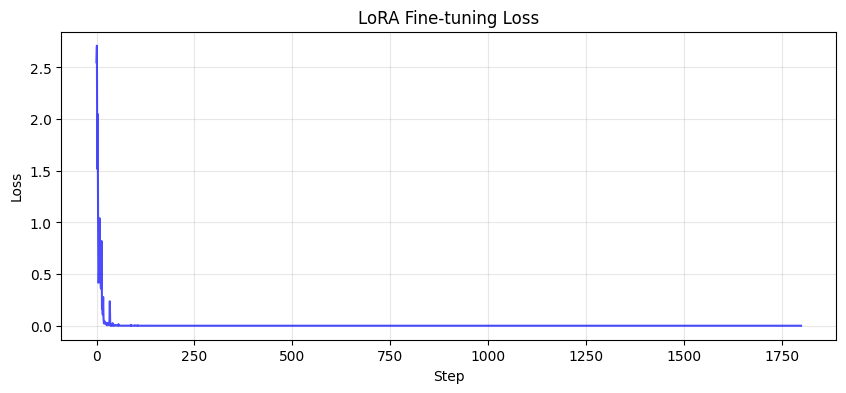

In [14]:
if PEFT_AVAILABLE and losses:
    # Visualize training
    plt.figure(figsize=(10, 4))
    plt.plot(losses, 'b-', alpha=0.7)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('LoRA Fine-tuning Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

In [15]:
# Test the fine-tuned model
def _clean_text(text: str) -> str:
    text = text.replace("##", "")
    return text.replace(" ", "").strip()

def _normalize_text(text: str) -> str:
    table = str.maketrans({
        "發": "发",
        "貨": "货",
        "異": "异",
        "後": "后",
        "諮": "咨",
        "詢": "询",
        "請": "请",
    })
    return text.translate(table)

def _trim_at_stop(text: str) -> str:
    for token in ["\n", "。", "！", "？", "，", "；", "、", "/", "／", " "]:
        idx = text.find(token)
        if idx != -1:
            return text[:idx]
    return text

def _extract_label(text: str, labels) -> str:
    normalized = _normalize_text(text)
    for label in labels:
        if label in normalized:
            return label
    return "未识别"

def generate_answer(model, tokenizer, text, max_new_tokens=8, temperature=0.7, do_sample=False, top_p=0.9):
    model.eval()
    prompt = format_prompt(text)
    model_device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors='pt').to(model_device)

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = tokenizer.pad_token_id

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "repetition_penalty": 1.05,
        "no_repeat_ngram_size": 3,
        "min_new_tokens": 2,
    }
    if do_sample:
        gen_kwargs["temperature"] = temperature
        gen_kwargs["top_p"] = top_p

    input_len = inputs['input_ids'].shape[-1]
    with torch.no_grad():
        try:
            outputs = model.generate(
                **inputs,
                **gen_kwargs,
            )
        except TypeError:
            gen_kwargs.pop("min_new_tokens", None)
            outputs = model.generate(
                **inputs,
                **gen_kwargs,
            )

    gen_ids = outputs[0][input_len:]
    response = tokenizer.decode(gen_ids, skip_special_tokens=True)
    response = _trim_at_stop(_clean_text(response))
    return response if response else "（空）"

if PEFT_AVAILABLE:
    print("\n" + "="*60)
    print("对比：LoRA 训练前 vs 训练后")
    print("="*60)
    
    test_samples = _build_records(5, seed=123)
    test_texts = [s["text"] for s in test_samples]
    test_answers = [s["label"] for s in test_samples]
    
    # Reload base model for a clean before/after comparison
    print("Loading base model for comparison...")
    base_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    base_model.config.pad_token_id = tokenizer.pad_token_id
    
    base_answers = [generate_answer(base_model, tokenizer, t) for t in test_texts]
    lora_answers = [generate_answer(lora_model, tokenizer, t) for t in test_texts]
    
    for text, gold, base_a, lora_a in zip(test_texts, test_answers, base_answers, lora_answers):
        base_label = _extract_label(base_a, ISSUE_LABELS)
        lora_label = _extract_label(lora_a, ISSUE_LABELS)
        print(f"\nText: {text}")
        print(f"Gold: {gold}")
        print(f"Base: {base_a}")
        print(f"Base label: {base_label} | Exact: {base_label == gold}")
        print(f"LoRA: {lora_a}")
        print(f"LoRA label: {lora_label} | Exact: {lora_label == gold}")


对比：LoRA 训练前 vs 训练后
Loading base model for comparison...

Text: 订单OD20241199-6442相关用户陈磊邮箱cynidb@mail.com，反馈：发货很久没消息。
Gold: 延迟发货
Base: email@mail@mail___
Base label: 未识别 | Exact: False
LoRA: 延迟发货延迟發貨
LoRA label: 延迟发货 | Exact: True

Text: 李娜关于订单OD20240994-2435咨询：申请退款处理，联系方式krkwhf@example.com。
Gold: 退款申请
Base: id：krkwhf_
Base label: 未识别 | Exact: False
LoRA: 退款申请咨询退款
LoRA label: 退款申请 | Exact: True

Text: 用户张伟邮箱kxodbc@email.cn，订单号OD20240392-3068需要处理：迟迟未发货。
Gold: 延迟发货
Base: email@email@gmail.cn邮
Base label: 未识别 | Exact: False
LoRA: 修改发货问题修改
LoRA label: 未识别 | Exact: False

Text: 用户孙婷邮箱pipbyj@mail.com，订单号OD20241169-8912需要处理：物流一直不更新。
Gold: 物流异常
Base: 用户：pipbyj@
Base label: 未识别 | Exact: False
LoRA: 物流异常发生异常
LoRA label: 物流异常 | Exact: True

Text: 周凯关于订单OD20241096-9529咨询：订单一直待发货，联系方式yuqnvr@email.cn。
Gold: 延迟发货
Base: @gmail.com
Base label: 未识别 | Exact: False
LoRA: 延迟发货问题咨询
LoRA label: 延迟发货 | Exact: True


## Part 5：QLoRA - 量化与 LoRA 的结合

QLoRA = 4-bit 量化 + LoRA（只训练低秩适配器，基座权重保持量化冻结）。

### bitsandbytes 在里面扮演什么角色？
- 提供 8-bit/4-bit 权重量化与反量化的 CUDA kernel
- 支持 NF4（更贴近权重分布）和 Double Quant（量化量化参数本身）
- 常与 `device_map='auto'` 配合做分片加载，进一步省显存

### 关键配置项（对应 BitsAndBytesConfig）
- `load_in_4bit=True`：以 4-bit 权重加载模型
- `bnb_4bit_quant_type='nf4'`：NF4 量化，适合正态分布权重
- `bnb_4bit_use_double_quant=True`：双重量化，进一步压缩量化参数
- `bnb_4bit_compute_dtype=torch.bfloat16/float16`：计算精度

### 训练时发生了什么？
1. 基座模型权重保持 4-bit 冻结
2. LoRA 在指定层插入 A/B 低秩矩阵（通常只占 0.1%~2% 参数）
3. 反向传播只更新 LoRA 参数（与少量 LayerNorm）
4. 推理时 LoRA 权重与基座权重“合并”或“并行生效”

### 适用与限制
- 适合 7B+ 模型在消费级 GPU 上微调
- Windows 下 bitsandbytes 兼容性可能较弱，必要时用 WSL2
- 量化会带来一定精度损失，但 LoRA 可部分补偿

下面给出**可运行的小型 QLoRA 演示**（如果 CUDA + bitsandbytes 可用）。


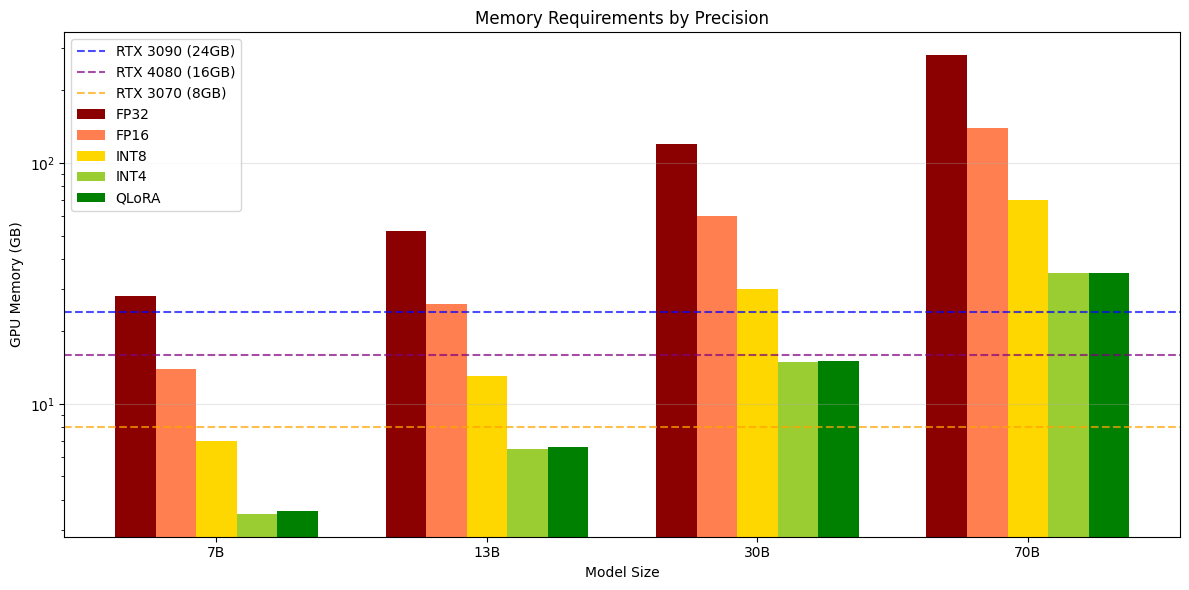


QLoRA enables fine-tuning on consumer GPUs:
  7B model with QLoRA: ~3.6 GB (fits on 8GB GPU!)
  13B model with QLoRA: ~6.6 GB (fits on 16GB GPU!)
  30B model with QLoRA: ~15.1 GB (fits on 24GB GPU!)


In [16]:
# Memory requirements comparison
model_sizes = ['7B', '13B', '30B', '70B']
params_b = [7, 13, 30, 70]

# Memory estimates (GB)
fp32_mem = [p * 4 for p in params_b]  # FP32: 4 bytes/param
fp16_mem = [p * 2 for p in params_b]  # FP16: 2 bytes/param
int8_mem = [p * 1 for p in params_b]  # INT8: 1 byte/param
int4_mem = [p * 0.5 for p in params_b]  # INT4: 0.5 bytes/param
qlora_mem = [p * 0.5 + 0.1 for p in params_b]  # INT4 + LoRA overhead

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_sizes))
width = 0.15

ax.bar(x - 2*width, fp32_mem, width, label='FP32', color='darkred')
ax.bar(x - width, fp16_mem, width, label='FP16', color='coral')
ax.bar(x, int8_mem, width, label='INT8', color='gold')
ax.bar(x + width, int4_mem, width, label='INT4', color='yellowgreen')
ax.bar(x + 2*width, qlora_mem, width, label='QLoRA', color='green')

# Add GPU memory lines
ax.axhline(y=24, color='blue', linestyle='--', alpha=0.7, label='RTX 3090 (24GB)')
ax.axhline(y=16, color='purple', linestyle='--', alpha=0.7, label='RTX 4080 (16GB)')
ax.axhline(y=8, color='orange', linestyle='--', alpha=0.7, label='RTX 3070 (8GB)')

ax.set_xlabel('Model Size')
ax.set_ylabel('GPU Memory (GB)')
ax.set_title('Memory Requirements by Precision')
ax.set_xticks(x)
ax.set_xticklabels(model_sizes)
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nQLoRA enables fine-tuning on consumer GPUs:")
print(f"  7B model with QLoRA: ~{qlora_mem[0]:.1f} GB (fits on 8GB GPU!)")
print(f"  13B model with QLoRA: ~{qlora_mem[1]:.1f} GB (fits on 16GB GPU!)")
print(f"  30B model with QLoRA: ~{qlora_mem[2]:.1f} GB (fits on 24GB GPU!)")

In [17]:
# QLoRA configuration example (requires bitsandbytes)
qlora_code = '''
# QLoRA Configuration Example
# This requires: pip install bitsandbytes

from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,  # Nested quantization
    bnb_4bit_quant_type="nf4",       # NormalFloat4
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

# Apply LoRA on top of quantized model
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
'''

print("QLoRA Example Code:")
print("=" * 60)
print(qlora_code)

QLoRA Example Code:

# QLoRA Configuration Example
# This requires: pip install bitsandbytes

from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,  # Nested quantization
    bnb_4bit_quant_type="nf4",       # NormalFloat4
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

# Apply LoRA on top of quantized model
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)



### 可选：QLoRA 迷你实操（CUDA + bitsandbytes）

下面是一个**小模型**（OPT-125M）的 QLoRA 迷你训练示例，跑 20~40 step 方便观察。
如果没有安装 bitsandbytes，先执行 `pip install bitsandbytes`。
Windows 若遇到安装失败，可考虑 WSL2/Linux。


In [18]:
# Optional: runnable QLoRA mini demo (requires CUDA + bitsandbytes)
if not PEFT_AVAILABLE:
    print("PEFT not available. Install with: pip install peft")
elif not BNB_AVAILABLE:
    print("bitsandbytes not available. Install with: pip install bitsandbytes")
elif not torch.cuda.is_available():
    print("CUDA not available. QLoRA demo skipped.")
else:
    from transformers import BitsAndBytesConfig

    qlora_model_name = "uer/gpt2-chinese-cluecorpussmall"
    compute_dtype = torch.bfloat16 if hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported() else torch.float16

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )

    qlora_tokenizer = AutoTokenizer.from_pretrained(qlora_model_name)
    if qlora_tokenizer.pad_token is None:
        qlora_tokenizer.pad_token = qlora_tokenizer.eos_token or qlora_tokenizer.unk_token

    qlora_base = AutoModelForCausalLM.from_pretrained(
        qlora_model_name,
        quantization_config=bnb_config,
        device_map="auto"
    )
    qlora_base = prepare_model_for_kbit_training(qlora_base)
    qlora_base.config.use_cache = False

    qlora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules=["c_attn", "c_proj"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )

    qlora_model = get_peft_model(qlora_base, qlora_config)
    qlora_model.print_trainable_parameters()

    qlora_train_samples = _build_records(800, seed=7)
    qlora_dataset = TextDataset(qlora_train_samples, qlora_tokenizer, max_length=128)
    qlora_loader = DataLoader(qlora_dataset, batch_size=8, shuffle=True)

    optimizer = torch.optim.AdamW(qlora_model.parameters(), lr=2e-4)
    qlora_model.train()

    max_steps = 80
    step = 0
    for epoch in range(2):
        for batch in qlora_loader:
            device = next(qlora_model.parameters()).device
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = qlora_model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step % 10 == 0:
                print(f"step {step} | loss {loss.item():.4f}")
            step += 1
            if step >= max_steps:
                break
        if step >= max_steps:
            break

    qlora_model.eval()
    demo_samples = _build_records(3, seed=123)
    for sample in demo_samples:
        pred_raw = generate_answer(qlora_model, qlora_tokenizer, sample["text"])
        pred_label = _extract_label(pred_raw, ISSUE_LABELS)
        print(f"Text: {sample['text']}")
        print(f"Gold: {sample['label']}")
        print(f"Pred raw: {pred_raw}")
        print(f"Pred: {pred_label}")


trainable params: 1,622,016 || all params: 103,690,752 || trainable%: 1.5643
step 0 | loss 3.1893
step 10 | loss 1.7123
step 20 | loss 0.6141
step 30 | loss 0.1610
step 40 | loss 0.0640
step 50 | loss 0.0228
step 60 | loss 0.0053
step 70 | loss 0.0031
Text: 订单OD20241199-6442相关用户陈磊邮箱cynidb@mail.com，反馈：发货很久没消息。
Gold: 延迟发货
Pred raw: 延迟发货延迟延迟
Pred: 延迟发货
Text: 李娜关于订单OD20240994-2435咨询：申请退款处理，联系方式krkwhf@example.com。
Gold: 退款申请
Pred raw: 退款申请咨询申请
Pred: 退款申请
Text: 用户张伟邮箱kxodbc@email.cn，订单号OD20240392-3068需要处理：迟迟未发货。
Gold: 延迟发货
Pred raw: 延迟发货延迟發貨
Pred: 延迟发货


## 总结

1. **LoRA 原理**：低秩分解使可训练参数减少 100x+
   - 只训练小矩阵 A 和 B
   - 原始权重保持冻结

2. **量化**：降低精度以节省显存
   - FP32 → FP16 → INT8 → INT4
   - 权衡：显存节省 vs. 精度

3. **QLoRA**：两者结合
   - 4-bit 量化的基座模型
   - LoRA 作为可训练参数
   - 消费级 GPU 上也能微调 7B+ 模型

### 关键公式

| 概念 | 公式 |
|---------|--------|
| LoRA | $W_{new} = W_{frozen} + BA$ |
| Scaling | $\alpha / r$ |
| 压缩比 | $(d_{in} \times d_{out}) / (d_{in} \times r + r \times d_{out})$ |



## 练习

1. **秩的对比**：用不同 rank（4、8、16、32）训练并比较效果
2. **目标模块**：尝试把 LoRA 应用于不同层
3. **权重合并**：实现权重合并并验证推理是否正常
4. **4-bit 量化**：如果有 bitsandbytes，尝试在更大模型上做 QLoRA


In [19]:
# Exercise space

